<a href="https://colab.research.google.com/github/eomiso/colab/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TODO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-s34co4at
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-s34co4at
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=23e757ab32fa19849aa1361864d08dbfff101d0e40b2ce78d821f0aa47511f13
  Stored in directory: /tmp/pip-ephem-wheel-cache-xf132gkw/wheels/d6/38/42/3d2112bc7d915f6195254ac85eb761d922d1b18f52817aa8e2
Successfully built mnist1d


In [2]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [81]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [82]:
print(data.keys())


dict_keys(['x', 'x_test', 'y', 'y_test', 't', 'templates'])


array([[-0.33200567, -0.47191037, -0.77869708, ..., -0.7167305 ,
        -0.96195825, -0.89016639],
       [ 1.96548088,  2.30021254,  2.21339278, ..., -1.68751297,
        -1.42642212, -1.36421511],
       [-0.01930303,  0.07863308,  0.62488909, ..., -1.08555748,
        -1.79809121, -2.3153282 ],
       ...,
       [-1.69449348, -1.2805858 , -0.65125255, ..., -0.72365942,
        -0.38266551, -0.03165042],
       [ 0.99646721,  0.80844603,  0.1553411 , ..., -0.30286571,
        -0.28555128, -0.1183879 ],
       [-0.6939948 , -0.27532169,  0.29267968, ..., -1.21624513,
        -1.4649417 , -1.65099286]])

In [95]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TODO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
    torch.nn.Linear(D_i, D_k),
    torch.nn.ReLU(),
    torch.nn.Linear(D_k, D_k),
    torch.nn.ReLU(),
    torch.nn.Linear(D_k, D_o),
    )


def weights_init(layer_in):
  # TODO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=lambda: np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 150
# store the loss and the % correct at each epoch
losses_train = np.zeros((40*n_epoch))
errors_train = np.zeros((40*n_epoch))
losses_test = np.zeros((40*n_epoch))
errors_test = np.zeros((40*n_epoch))

step = 0
for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    with torch.no_grad():
      pred_train = model(x_train)
      pred_test = model(x_test)
      _, predicted_train_class = torch.max(pred_train.data, 1)
      _, predicted_test_class = torch.max(pred_test.data, 1)
      errors_train[step] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
      errors_test[step]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
      losses_train[step] = loss_function(pred_train, y_train).item()
      losses_test[step]= loss_function(pred_test, y_test).item()

    step += 1
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch*40]:.6f}, train error {errors_train[epoch*40]:3.2f},  test loss {losses_test[epoch*40]:.6f}, test error {errors_test[epoch*40]:3.2f}')

  # tell scheduler to consider updating learning rate
  # scheduler.step()

Epoch     0, train loss 2.769301, train error 88.72,  test loss 2.761657, test error 86.40
Epoch     1, train loss 1.771815, train error 68.88,  test loss 1.810515, test error 70.90
Epoch     2, train loss 1.606782, train error 62.10,  test loss 1.683208, test error 66.60
Epoch     3, train loss 1.512655, train error 56.30,  test loss 1.605676, test error 60.40
Epoch     4, train loss 1.454204, train error 55.55,  test loss 1.579686, test error 62.00
Epoch     5, train loss 1.369184, train error 50.00,  test loss 1.514455, test error 57.10
Epoch     6, train loss 1.303497, train error 46.80,  test loss 1.467931, test error 57.70
Epoch     7, train loss 1.238738, train error 43.67,  test loss 1.408807, test error 54.60
Epoch     8, train loss 1.189307, train error 41.53,  test loss 1.386753, test error 54.60
Epoch     9, train loss 1.141439, train error 39.80,  test loss 1.346835, test error 52.80
Epoch    10, train loss 1.096282, train error 38.55,  test loss 1.325144, test error 51.30

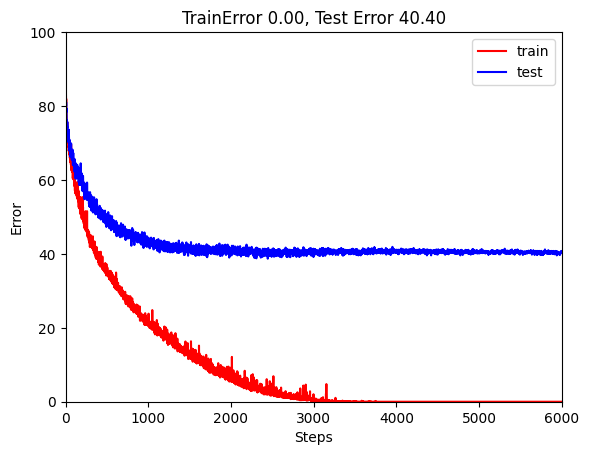

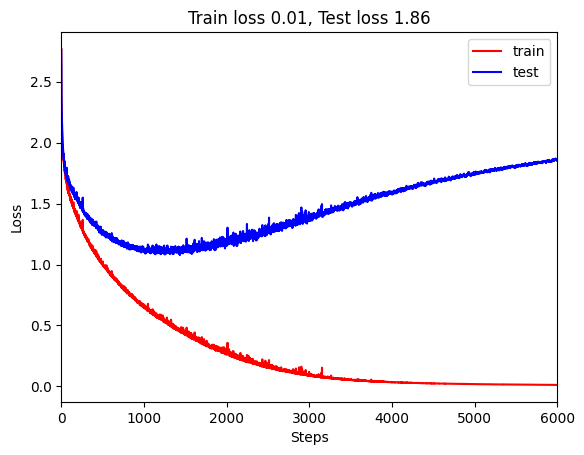

In [96]:
# Plot the results
fig, ax = plt.subplots()
# The data is already stored per step, so we just need to plot it
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
# Set x-axis limit to the total number of steps
ax.set_ylim(0,100); ax.set_xlim(0, len(errors_train)) # Use len(errors_train) for total steps
ax.set_xlabel('Steps'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
# The data is already stored per step, so we just need to plot it
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
# Set x-axis limit to the total number of steps
ax.set_xlim(0, len(losses_train)) # Use len(losses_train) for total steps
ax.set_xlabel('Steps'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

## 더 빨리 학습을 끝내는 방법

StepLR 을 사용하고, momentum을 쓴다면 더 빨리 끝낼 수 있다.

**TODO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?